In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ray tracing
from OceanRays.SoundSpeed import CTDSoundSpeed
from OceanRays.RayPaths import RayTrace,plotProfileRaypaths

/Users/an77/anaconda3/envs/oceanrays/lib/python3.13/site-packages/seabird/cnv.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# Build a Sound Speed Profile using exising CTD data (example is from a deep-water cast collected in 20204 near the AK trench)
# From CTD Data
infile='../CTD_examples/SKQ202409S_009.cnv'
profile, CMac = CTDSoundSpeed(infile)

Profile ../CTD_examples/SKQ202409S_009.cnv 
   taken at 53.0355, -163.5385
   Date Time 2024-06-28 15:37:10


## Testing plots of CTD profile
can ignore

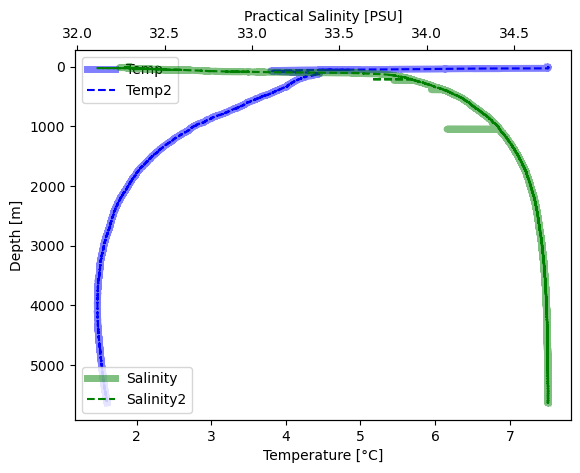

In [4]:
plt.plot(profile['TEMP'],profile['DEPTH'], 'b', alpha=0.5,linewidth=5, label='Temp')
plt.plot(profile['TEMP2'],profile['DEPTH'], 'b--', label='Temp2')
plt.legend()
plt.xlabel('Temperature [°C]')
plt.ylabel('Depth [m]')

plt.twiny()
plt.plot(profile['PSAL'],profile['DEPTH'], 'g',alpha=0.5,linewidth=5, label='Salinity')
plt.plot(profile['PSAL2'],profile['DEPTH'], 'g--', label='Salinity2')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('Practical Salinity [PSU]')
plt.show()


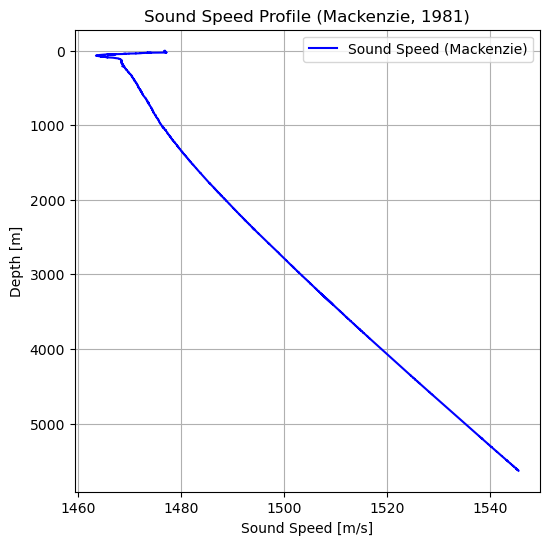

In [5]:

plt.figure(figsize=(6,6))
plt.plot(CMac, profile['DEPTH'], 'b', label='Sound Speed (Mackenzie)')
plt.gca().invert_yaxis()
plt.xlabel('Sound Speed [m/s]')
plt.ylabel('Depth [m]')
plt.title('Sound Speed Profile (Mackenzie, 1981)')
plt.legend()
plt.grid(True)
plt.show()